## Cat vs Dogs

Dataset : https://www.kaggle.com/c/dogs-vs-cats

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import os
from PIL import Image
from torchvision import transforms
import numpy as np
from torchvision.utils import make_grid

In [2]:
base_dir = './datasets/catvsdog/'

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [4]:
class CVD_dataset(Dataset):
    def __init__(self, base_dir, split="train", trans=None):
        path = os.path.join(base_dir, f'{split}')            
        files = os.listdir(path)                                                       
        self.filenames = [os.path.join(path,f) for f in files if f.endswith('.jpg')] 
        self.targets = [0 if f[0]=='c' else 1 for f in files ]
        self.trans = trans
        # self.target_labels = [f[:3] for f in files]
            
    # return length of files in the directory
    def __len__(self):
        return len(self.filenames)
    
    # return image and target
    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])
        if self.trans:
            image = self.trans(image)
        return image, self.targets[idx]

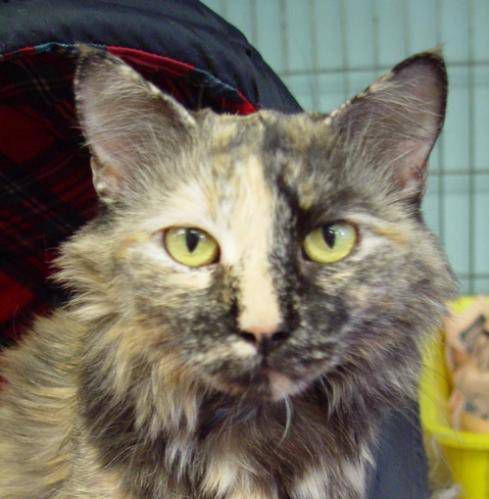

In [5]:
tset = CVD_dataset(base_dir, split='train/cats')
tset += CVD_dataset(base_dir, split='train/dogs')
tset[2][0]

In [6]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])



In [7]:
trainset = CVD_dataset(base_dir, split='train/cats', trans=train_transforms)
trainset += CVD_dataset(base_dir, split='train/dogs', trans=train_transforms)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

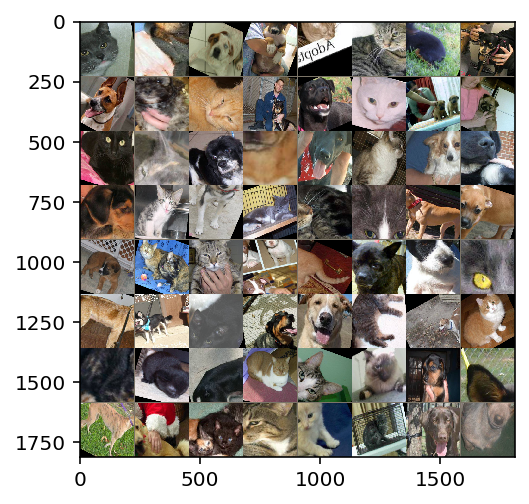

tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1])


In [8]:

for inputs, targets in trainloader:
    out = make_grid(inputs)
    imshow(out)
    print(targets)
    break

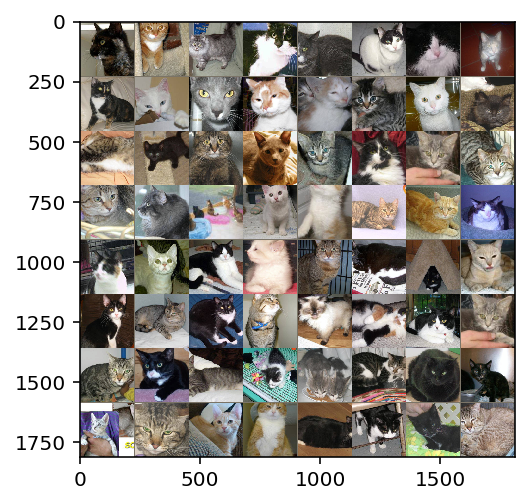

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [9]:
testset = CVD_dataset(base_dir, split='test/cats', trans=test_transforms)
testset += CVD_dataset(base_dir, split='test/dogs', trans=test_transforms)
testloader = DataLoader(testset, batch_size=64)

for inputs, targets in testloader:
    out = make_grid(inputs)
    imshow(out)
    print(targets)
    break

In [10]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [11]:
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 512)),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(512,256)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(256, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [14]:
traininglosses = []
testinglosses = []
testaccuracy = []
totalsteps = []
epochs = 1
steps = 0
running_loss = 0
print_every = 10
for epoch in range(epochs):
    for inputs, targets in trainloader:
        steps += 1
        # To GPU
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, targets in testloader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, targets)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == targets.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            traininglosses.append(running_loss/print_every)
            testinglosses.append(test_loss/len(testloader))
            testaccuracy.append(accuracy/len(testloader))
            totalsteps.append(steps)
            print('-'*64)
            print(f"Epoch {epoch+1}/{epochs}  "
                  f"\tStep {steps}  "
                  f"\tTrain loss: {running_loss/print_every:.4f}  "
                  f"\tTest loss: {test_loss/len(testloader):.4f}  "
                  f"\tAccuracy: {accuracy/len(testloader):.4f}")
            running_loss = 0
            model.train()

----------------------------------------------------------------
Epoch 1/1  	Step 10  	Train loss: 0.1252  	Test loss: 0.1109  	Accuracy: 0.9861
----------------------------------------------------------------
Epoch 1/1  	Step 20  	Train loss: 0.1226  	Test loss: 0.1292  	Accuracy: 0.9830
----------------------------------------------------------------
Epoch 1/1  	Step 30  	Train loss: 0.1684  	Test loss: 0.0918  	Accuracy: 0.9861
----------------------------------------------------------------
Epoch 1/1  	Step 40  	Train loss: 0.1371  	Test loss: 0.0854  	Accuracy: 0.9861
----------------------------------------------------------------
Epoch 1/1  	Step 50  	Train loss: 0.1550  	Test loss: 0.0867  	Accuracy: 0.9861
----------------------------------------------------------------
Epoch 1/1  	Step 60  	Train loss: 0.1505  	Test loss: 0.0867  	Accuracy: 0.9830
----------------------------------------------------------------
Epoch 1/1  	Step 70  	Train loss: 0.1386  	Test loss: 0.0920  	Ac

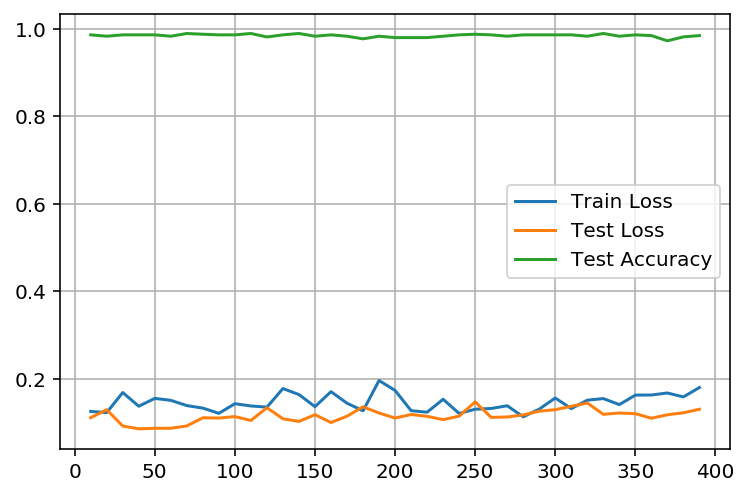

In [15]:
from matplotlib import pyplot as plt
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, testinglosses, label='Test Loss')
plt.plot(totalsteps, testaccuracy, label='Test Accuracy')
plt.legend()
plt.grid()
plt.show()

In [16]:
checkpoint = {
    'parameters' : model.parameters,
    'state_dict' : model.state_dict()
}

In [17]:
torch.save(checkpoint, './catvdogs_v2.pth')

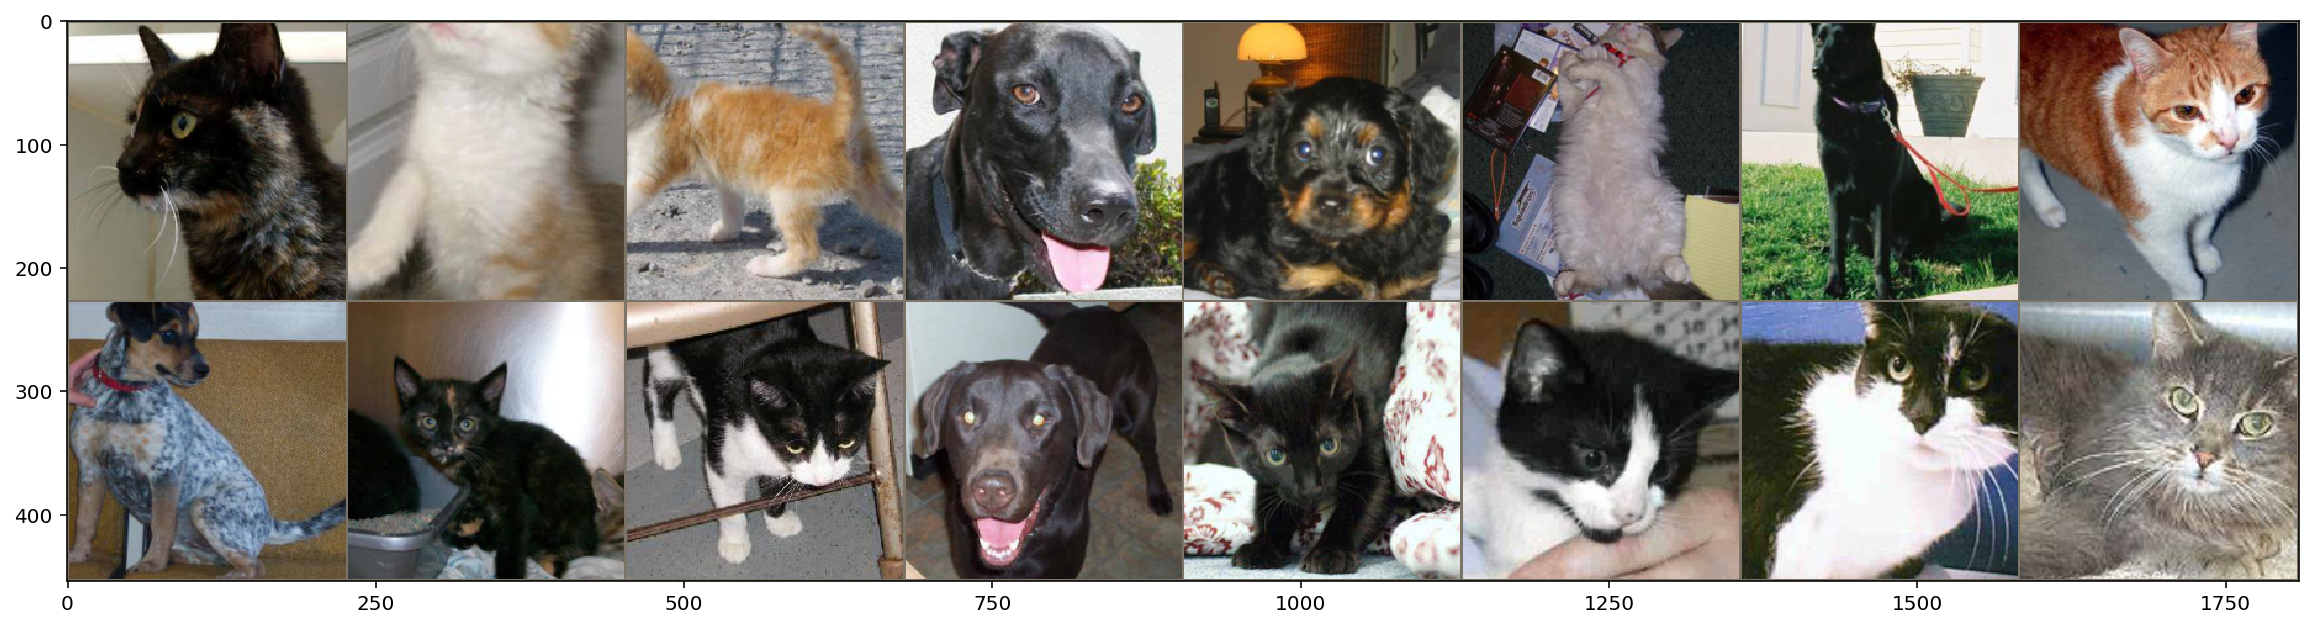

Targets: ['cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat']
Predictions: ['cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat']
Equals?: True


In [19]:
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

testset = CVD_dataset(base_dir, split='test/cats', trans=test_transforms)
testset += CVD_dataset(base_dir, split='test/dogs', trans=test_transforms)
testloader = DataLoader(testset, batch_size=16, shuffle=True)

inputs_out = []
outputs = []

plt.rcParams["figure.figsize"] = (20,20)

labels = ['cat','dog']

for inputs, targets in testloader:
    out = make_grid(inputs)
    imshow(out)
    inputs, targets = inputs.to(device), targets.to(device) # to gpu
    outputs = model(inputs)
    _, pred = torch.max(outputs, 1)
    
    tar = [labels[l] for l in pred]
    pred = [labels[l] for l in pred]
    print(f'Targets: {tar}')
    print(f'Predictions: {pred}')
    print(f'Equals?: {tar == pred}')
    break
